In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

# load the cifar10 datasets
cifar10_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
cifar10_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=None)
cifar10_trainset.targets = torch.tensor(cifar10_trainset.targets).clone().detach()
cifar10_testset.targets = torch.tensor(cifar10_testset.targets).clone().detach()

# split frog and ship data and label 1, -1 respectively
frogs_train = cifar10_trainset.data[cifar10_trainset.targets == 6, :, :, :]
ships_train = cifar10_trainset.data[cifar10_trainset.targets == 8, :, :, :]
train_len = len(frogs_train.data)
frogs_train = [(1, frogs_train[i, :, :, :]) for i in range(train_len)]
ships_train = [(-1, ships_train[i, :, :, :]) for i in range(train_len)]

# calculate mean pixel intensity for each colour for frogs and ships
frogs_red_mean = np.mean([frogs_train[i][1][:,:,0]/255 for i in range(train_len)])
frogs_green_mean = np.mean([frogs_train[i][1][:,:,1]/255 for i in range(train_len)])
frogs_blue_mean = np.mean([frogs_train[i][1][:,:,2]/255 for i in range(train_len)])
ships_red_mean = np.mean([ships_train[i][1][:,:,0]/255 for i in range(train_len)])
ships_green_mean = np.mean([ships_train[i][1][:,:,1]/255 for i in range(train_len)])
ships_blue_mean = np.mean([ships_train[i][1][:,:,2]/255 for i in range(train_len)])

print("Respective R,G,B means for frog images:", frogs_red_mean, frogs_green_mean, frogs_blue_mean, "\n")
print("Respective R,G,B means for ship images:", ships_red_mean, ships_green_mean, ships_blue_mean)

Files already downloaded and verified
Files already downloaded and verified
Respective R,G,B means for frog images: 0.47005706035539196 0.43839367647058824 0.345219072457108 

Respective R,G,B means for ship images: 0.4902259252450977 0.5253946185661772 0.5546856449142159


In [267]:
beta = 0.5 # temporarily fix beta as 0.5

# create empty ndarrays for the greyscale images
frogs_grey_train = np.ndarray((train_len, 32, 32, 1))
ships_grey_train = np.ndarray((train_len, 32, 32, 1))

def colour_merge(red, green, blue, beta):
    '''returns a greyscaled pixel intensity determined by beta'''
    return 0.1*red + (0.9 - beta)*green + beta*blue

def greyscale(rgb_data, grey_data, beta):
    '''converts an RGB image into a greyscale image'''
    for i in range(len(rgb_data)):
        for j in range(len(rgb_data[0][1])):
            for k in range(len(rgb_data[0][1][1])):
                grey_data[i,j,k] = \
                colour_merge(rgb_data[i][1][j,k,0], rgb_data[i][1][j,k,1], rgb_data[i][1][j,k,2], beta)
    return grey_data

# convert frog and ship data to greyscale
frogs_grey_train = greyscale(frogs_train, frogs_grey_train, beta)
ships_grey_train = greyscale(ships_train, ships_grey_train, beta)

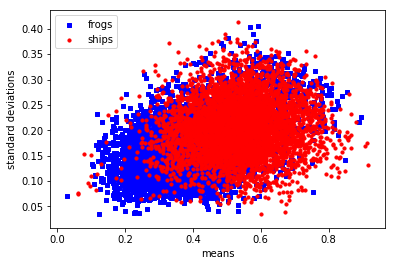

In [268]:
# calculate, for each image, mean and standar deviation greyscale pixel intensity
frogs_grey_means = [np.mean(frogs_grey_train[i,:,:]/255) for i in range(train_len)]
frogs_grey_sds = [np.std(frogs_grey_train[i,:,:]/255) for i in range(train_len)]
ships_grey_means = [np.mean(ships_grey_train[i,:,:]/255) for i in range(train_len)]
ships_grey_sds = [np.std(ships_grey_train[i,:,:]/255) for i in range(train_len)]

# plot the results in a scatterplot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(frogs_grey_means, frogs_grey_sds, s=10, c='b', marker="s", label='frogs')
ax1.scatter(ships_grey_means,ships_grey_sds, s=10, c='r', marker="o", label='ships')
plt.legend(loc='upper left'), plt.xlabel("means"), plt.ylabel("standard deviations")
plt.show()

In [274]:
gamma = 0.5 # temporarily fix gamma as 0.5

def classifier(mean, std, gamma):
    '''classifies an image as 1 if its square mean and 
    standard deviation is <= gamma and -1 otherwise'''
    if mean*mean + std*std <= gamma:
        return 1
    else:
        return -1
    
# make predictions for each class based upon the classifier defined above
frogs_pred = [classifier(frogs_grey_means[i], frogs_grey_sds[i], gamma) for i in range(train_len)]
ships_pred = [classifier(ships_grey_means[i], ships_grey_sds[i], gamma) for i in range(train_len)]

# calculate the number of TPs, FPs, FNs and TNs for each class
TPs = np.sum(frogs_pred == np.ones(train_len))
FPs = np.sum(ships_pred == np.ones(train_len))
FNs = np.sum(frogs_pred == np.negative(np.ones(train_len)))
TNs = np.sum(ships_pred == np.negative(np.ones(train_len)))

def precision(TP, FP):
    '''returns the precision score'''
    return TP / (TP + FP)

def recall(TP, FN):
    '''returns the recall score'''
    return TP / (TP + FN)

def f1(precision, recall):
    '''returns the F1 score'''
    return 2*(precision*recall / (precision + recall))

# calculate precision, recall and F1 score for the naive classifier
precision_score = precision(TPs, FPs)
recall_score = recall(TPs, FNs)
f1_score = f1(precision_score, recall_score)
print("Precision: ", precision_score, " Recall: ", recall_score, " F1 Score: ", f1_score)

Precision:  0.5219132128557515  Recall:  0.9646  F1 Score:  0.6773400744329751


In [311]:
# parameter values for the grid search
beta = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gamma = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

f1_grid = np.zeros((8, 8))

# run the grid search across above parameter space
row = 0
for i in beta:
    col = 0
    frogs_grey_train = greyscale(frogs_train, frogs_grey_train, i)
    ships_grey_train = greyscale(ships_train, ships_grey_train, i)
    for j in gamma:
        frogs_grey_means = [np.mean(frogs_grey_train[k,:,:]/255) for k in range(train_len)]
        frogs_grey_sds = [np.std(frogs_grey_train[k,:,:]/255) for k in range(train_len)]
        ships_grey_means = [np.mean(ships_grey_train[k,:,:]/255) for k in range(train_len)]
        ships_grey_sds = [np.std(ships_grey_train[k,:,:]/255) for k in range(train_len)]
        frogs_pred = [classifier(frogs_grey_means[k], frogs_grey_sds[k], j) for k in range(train_len)]
        ships_pred = [classifier(ships_grey_means[k], ships_grey_sds[k], j) for k in range(train_len)]
        TPs = np.sum(frogs_pred == np.ones(train_len))
        FPs = np.sum(ships_pred == np.ones(train_len))
        FNs = np.sum(frogs_pred == np.negative(np.ones(train_len)))
        precision_score = precision(TPs, FPs)
        recall_score = recall(TPs, FNs)
        f1_grid[row,col] = f1(precision_score, recall_score)
        col = col + 1
    row = row + 1

In [349]:
import pandas as pd

# display the F1 scores for the grid search. 
f1_df = pd.DataFrame(f1_grid[:,1:], beta[:], gamma[1:])
print(f1_df)
print("\nThe greatest F1 Score is :", np.max(f1_grid))
print("This was achieved by setting: gamma = 0.3 and beta = 0.9")

          0.3       0.4       0.5       0.6       0.7       0.8       0.9
0.2  0.723572  0.691789  0.669797  0.666576  0.665864  0.666667  0.666667
0.3  0.738123  0.696597  0.673165  0.667345  0.666132  0.666667  0.666667
0.4  0.751028  0.701394  0.675089  0.668023  0.666310  0.666667  0.666667
0.5  0.759682  0.707462  0.677340  0.668792  0.666399  0.666667  0.666667
0.6  0.768046  0.712316  0.680231  0.669651  0.666577  0.666667  0.666667
0.7  0.775811  0.716374  0.682713  0.670106  0.666622  0.666622  0.666667
0.8  0.782656  0.721603  0.685112  0.671104  0.667068  0.666622  0.666667
0.9  0.787753  0.725943  0.687819  0.672380  0.667381  0.666667  0.666667

The greatest F1 Score is : 0.7877528901734104
This was achieved by setting: gamma = 0.3 and beta = 0.9


In [350]:
# optimised parameter values from the grid search
beta = 0.9
gamma = 0.3

frogs_test = cifar10_testset.data[cifar10_testset.targets == 6, :, :, :]
ships_test = cifar10_testset.data[cifar10_testset.targets == 8, :, :, :]
test_len = len(frogs_test.data)
frogs_test = [(1, frogs_test[i, :, :, :]) for i in range(test_len)]
ships_test = [(-1, ships_test[i, :, :, :]) for i in range(test_len)]


frogs_grey_test = np.ndarray((test_len, 32, 32, 1))
ships_grey_test = np.ndarray((test_len, 32, 32, 1))
frogs_grey_test = greyscale(frogs_test, frogs_grey_train, beta)
ships_grey_test = greyscale(ships_test, ships_grey_train, beta)

frogs_test_means = [np.mean(frogs_grey_test[i,:,:]/255) for i in range(test_len)]
frogs_test_sds = [np.std(frogs_grey_test[i,:,:]/255) for i in range(test_len)]
ships_test_means = [np.mean(ships_grey_test[i,:,:]/255) for i in range(test_len)]
ships_test_sds = [np.std(ships_grey_test[i,:,:]/255) for i in range(test_len)]

frogs_pred = [classifier(frogs_test_means[i], frogs_test_sds[i], gamma) for i in range(test_len)]
ships_pred = [classifier(ships_test_means[i], ships_test_sds[i], gamma) for i in range(test_len)]

TPs = np.sum(frogs_pred == np.ones(test_len))
FPs = np.sum(ships_pred == np.ones(test_len))
FNs = np.sum(frogs_pred == np.negative(np.ones(test_len)))
TNs = np.sum(ships_pred == np.negative(np.ones(test_len)))

precision_score = precision(TPs, FPs)
recall_score = recall(TPs, FNs,)
f1_score = f1(precision_score, recall_score)
print("Precision: ", precision_score, " Recall: ", recall_score, " F1 Score: ", f1_score)

Precision:  0.7104404567699837  Recall:  0.871  F1 Score:  0.7825696316262353


In [63]:
from sklearn.metrics import confusion_matrix

# create train datasets for each class and a test dataset
xtest = np.vstack([cifar10_testset.data[i].reshape(-1) for i in range(10000)])
ytrain = cifar10_trainset.targets.double()
ytest = cifar10_testset.targets.double()

# partition the data into each class
xtrain = []
for i in range(10): 
    xtr = cifar10_trainset.data[cifar10_trainset.targets == i, :, :, :]
    xtrain.append(np.vstack([xtr[j].reshape(-1) for j in range(len(xtr))]))
 
# train the linear classifier
a = np.ones(50000).reshape(-1,1)

# determine beta_hat for each classifier over the different training sizes
beta_hat_1000 = []
beta_hat_10000 = []
beta_hat_50000 = []
for i in range(10):
    A_1000 = (torch.from_numpy(np.hstack((a[:100], xtrain[i][:100]))))
    beta_hat_1000.append(torch.mv(torch.pinverse(A_1000), i*torch.ones(100).double()))
    
    A_10000 = (torch.from_numpy(np.hstack((a[:1000], xtrain[i][:1000]))))
    beta_hat_10000.append(torch.mv(torch.pinverse(A_10000), i*torch.ones(1000).double()))
    
    A_50000 = (torch.from_numpy(np.hstack((a[:5000], xtrain[i]))))
    beta_hat_50000.append(torch.mv(torch.pinverse(A_50000), i*torch.ones(5000).double()))

In [64]:
# define 10 binary classifiers for each training size
classify_1000 = lambda x : [torch.dot(beta_hat_1000[i], \
        torch.hstack((torch.tensor([1]).double(), x.reshape(-1).float()))) for i in range(10)]
classify_10000 = lambda x : [torch.dot(beta_hat_10000[i], \
        torch.hstack((torch.tensor([1]).double(), x.reshape(-1).float()))) for i in range(10)]
classify_50000 = lambda x : [torch.dot(beta_hat_50000[i], \
        torch.hstack((torch.tensor([1]).double(), x.reshape(-1).float()))) for i in range(10)]

# make prediction for each class on each test image
xtest = torch.from_numpy(xtest)
f_hat_1000 = [classify_1000(xtest[i]) for i in range(10000)]
f_hat_10000 = [classify_10000(xtest[i]) for i in range(10000)]
f_hat_50000 = [classify_50000(xtest[i]) for i in range(10000)]

In [84]:
np.sum(np.array([1,2,3])==np.array([1,2,3]))

3

In [89]:
# make predictions for the 1000 image classifier and evaluate accuracy
pred_1000 = np.array([np.argmax(f_hat_1000[i]) for i in range(10000)])
accuracy = np.sum(pred_1000 == np.array(ytest.double()))/len(ytest)
print("Test Accuracy on 1000 images: ", accuracy)

# make predictions for the 10000 image classifier and evaluate accuracy
pred_10000 = np.array([np.argmax(f_hat_10000[i]) for i in range(10000)])
accuracy = np.sum(pred_10000 == np.array(ytest))/len(ytest)
print("Test Accuracy on 10 000 images: ", accuracy)

# make predictions for the 50000 image classifier, 
# plot the confusion matrix and evaluate accuracy
pred_50000 = np.array([np.argmax(f_hat_50000[i]) for i in range(10000)])
confusion = confusion_matrix(ytest, pred_50000)
print("Confusion matrix for the classifier trained on 50000 images:")
print(confusion)
accuracy = np.sum(pred_50000 == np.array(ytest))/len(ytest)
print("Test Accuracy on 50 000 images: ", accuracy)

Test Accuracy on 1000 images:  0.0926
Test Accuracy on 10 000 images:  0.1067
Confusion matrix for the classifier trained on 50000 images:
[[   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]]
Test Accuracy on 50 000 images:  0.1


In [2]:
import numpy as np
import sympy 

def backtracking_line_search(f, grad, t, d, a, p = 0.5, beta= 1e-4):
    f_lam = sympy.lambdify((t1, t2), f)
    z = f_lam(t[0], t[1])
    g = [s.subs([(t1, t[0]), (t2, t[1])]).evalf() for s in grad]
    theta_next = t + a*d
    
    while f_lam(theta_next[0], theta_next[1]) > z + a*beta*np.dot(g, d):
        a *= p
        theta_next = t + a*d
    return a


t1, t2 = sympy.symbols('t1, t2', real=True)
f = (1.0 - t1)**2 + 50*(t2 - t1**2)**2
theta = (t1, t2)
grad = [f.diff(t) for t in theta]


t = np.array([-1, 0.5])
d = np.array([-1, -1.5])
a_init = 3.0
sol = backtracking_line_search(f, grad, t, d, a_init)

print('Solution:', sol)

Solution: 0.25
